# 1. Introduction

This tutorial is an introduction to Convolutional Neural Networks using TensorFlow 2.x Keras API. The dataset that we will work it is the MNIST dataset, a dataset of handwritten digits 0-9, and we will use a Sequential CNN to predict which digit was drawn.

In [1]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print(tf.__version__)

2.15.0


# 2. Data Preprocessing

Before building any ML model, it is important to preprocess the data. In fact, data preprocessing will generally take up the most time in any ML pipeline. The following module goes over the steps to preprocess the MNIST dataset for our purposes.

## 2.1 Load Data

Our first step is to load the data and divide it into a training and testing dataset. The MNIST dataset can be downloaded directly from TensorFlow and has already been divided. Run the next cell to import the data.

``` x_train ``` is the dataset of 28x28 images of handwritten digits that the model will be trained on.

```y_train``` is the dataset of labels that correspond to ```x_train```.

``` x_test ``` is the dataset of 28x28 images of handwritten digits that the model will be tested on.

```y_test``` is the dataset of labels that correspond to ```x_test```.

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


Run the following code to see the counts of each digit present in our training dataset.

<Axes: ylabel='count'>

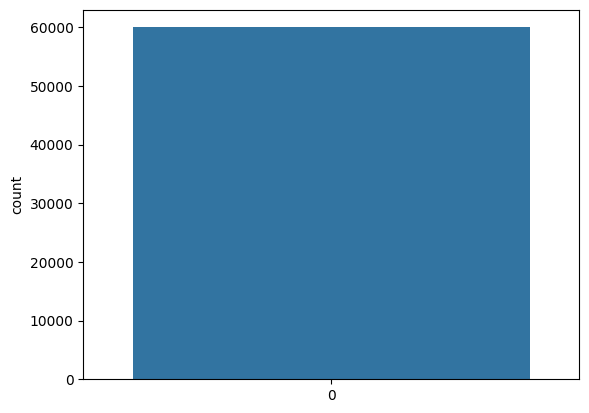

In [3]:
sns.countplot(y_train)

There are similar counts for each digit. This is good as the model will have enough images for each class to train the features for each class. There is no need to downsample or upweigh.

## 2.2 Check for NaN Values

In [4]:
np.isnan(x_train).any()

False

In [5]:
np.isnan(x_test).any()

False

There are no NaN values in our dataset. There is no need to preprocess the data to deal with Nan's.

## 2.3 Normalization and Reshaping

Since the values in our ```x_train``` dataset are 28x28 images, our input shape must be specified so that our model will know what is being inputed.

The first convolution layer expects a single 60000x28x28x1 tensor instead of 60000 28x28x1 tensors.

Models generally run better on normalized values. The best way to normalize the data depends on each individual dataset. For the MNIST dataset, we want each value to be between 0.0 and 1.0. As all values originally fall under the 0.0-255.0 range, divide by 255.0.

Run the following cell to define the ```input_shape``` and to normalize and reshape the data.

In [6]:
input_shape = (28, 28, 1)

x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test=x_test/255.0

## 2.4 Label Encoding

The labels for the training and the testing dataset are currently categorical and is not continuous. To include categorical dataset in our model, our labels should be converted to one-hot encodings.

For example, ```2``` becomes ```[0,0,1,0,0,0,0,0,0,0]``` and ```7``` becomes ```[0,0,0,0,0,0,0,1,0,0]```.

Run the following cell to transform the labels into one-hot encodings

In [7]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

## 2.5 Visualize Data

Run the following cell to visualize an image in our dataset.

tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)


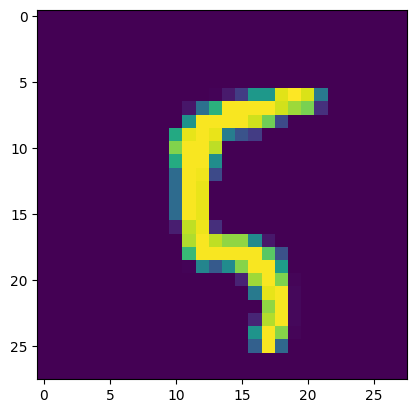

In [8]:
plt.imshow(x_train[100][:,:,0])
print(y_train[100])

The image is an image of a handwritten ```5```. The one-hot encoding holds the value of ```5```.

# 3. CNN

In this module, we will build our CNN model.

## 3.1 Define the Model

Run the following cell to define ```batch_size```, ```num_classes```, and ```epochs```. Try changing the values and test how different values affect the accuracy of the CNN model.

In [9]:
batch_size = 64
num_classes = 10
epochs = 5

Run the following cell to build the model. The model contains various layers stacked on top of each other. The output of one layer feeds into the input of the next layer.

Conv2D layers are convolutions. Each filter (32 in the first two convolution layers and 64 in the next two convolution layers) transforms a part of the image (5x5 for the first two Conv2D layers and 3x3 for the next two Conv2D layers). The transformation is applied on the whole image.

MaxPool2D is a downsampling filter. It reduces a 2x2 matrix of the image to a single pixel with the maximum value of the 2x2 matrix. The filter aims to conserve the main features of the image while reducing the size.

Dropout is a regularization layer. In our model, 25% of the nodes in the layer are randomly ignores, allowing the network to learn different features. This prevents overfitting.

```relu``` is the rectifier, and it is used to find nonlinearity in the data. It works by returning the input value if the input value >= 0. If the input is negative, it returns 0.

Flatten converts the tensors into a 1D vector.

The Dense layers are an artificial neural network (ANN). The last layer returns the probability that an image is in each class (one for each digit).

As this model aims to categorize the images, we will use a ```categorical_crossentropy``` loss function.

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])


## 3.2 Fit the Training Data

The next step is to fit our training data. If we achieve a certain level of accuracy, it may not be necessary to continue training the model, especially if time and resources are limited.

The following cell defines a CallBack so that if 99.5% accuracy is achieved, the model stops training. The model is not likely to stop prematurely if only 5 epochs are specified. Try it out with more epochs.

In [11]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.995):
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

Testing the model on a validation dataset prevents overfitting of the data. We specified a 10% validation and 90% training split.

In [12]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[callbacks])

Epoch 1/5
844/844 [==============================] - 212s 250ms/step - loss: 0.2267 - acc: 0.9301 - val_loss: 0.0489 - val_acc: 0.9860
Epoch 2/5
844/844 [==============================] - 204s 242ms/step - loss: 0.0762 - acc: 0.9781 - val_loss: 0.0405 - val_acc: 0.9895
Epoch 3/5
844/844 [==============================] - 200s 237ms/step - loss: 0.0577 - acc: 0.9833 - val_loss: 0.0417 - val_acc: 0.9878
Epoch 4/5
844/844 [==============================] - 199s 236ms/step - loss: 0.0478 - acc: 0.9870 - val_loss: 0.0392 - val_acc: 0.9907
Epoch 5/5
844/844 [==============================] - 198s 235ms/step - loss: 0.0448 - acc: 0.9870 - val_loss: 0.0415 - val_acc: 0.9898


# 4. Evaluate the Model

## 4.1 Loss and Accuracy Curves

Run the following cell to evaluate the loss and accuracy of our model.

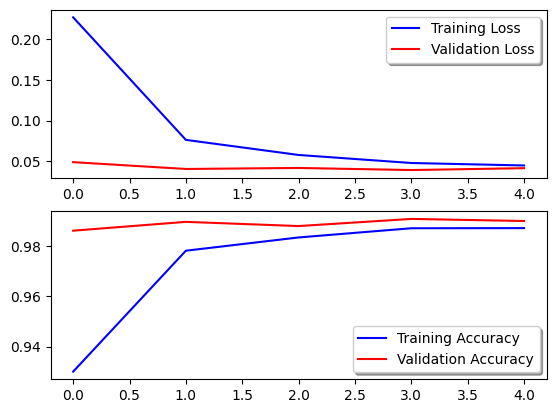

In [13]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

The accuracy increases over time and the loss decreases over time. However, the accuracy of our validation set seems to slightly decrease towards the end even thought our training accuracy increased. Running the model for more epochs might cause our model to be susceptible to overfitting.

## 4.2 Predict Results

In [14]:
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 10s 32ms/step - loss: 0.0278 - acc: 0.9923


Our model runs pretty well, with an accuracy of 99.3% on our testing data.

## 4.3 Confusion Matrix

Run the following cell to compute our confusion matrix using TensorFlow.

In [15]:
# Predict the values from the testing dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert testing observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)

313/313 [==============================] - 10s 33ms/step


Run the following cell to plot the confusion matrix.

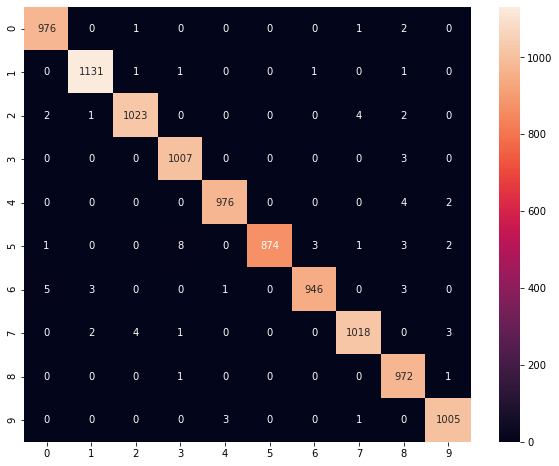

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')

There seems to be a slightly higher confusion between (0,6) and (4,9). This is reasonable as 0's and 6's look similar with their loops and 4's and 9's can be mistaken when the 4's are more rounded and 9's are more angular.